In [80]:
import warnings
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import pandas as pd
import numpy as np
from numpy import dot
from numpy.linalg import norm

warnings.filterwarnings('ignore')

In [115]:
df = pd.read_csv('sam22y.csv')
df.index

RangeIndex(start=0, stop=5560, step=1)

In [116]:
df.set_index('Date', drop=True, inplace=True)

In [118]:
df.index

Index(['2000-01-04', '2000-01-05', '2000-01-06', '2000-01-07', '2000-01-10',
       '2000-01-11', '2000-01-12', '2000-01-13', '2000-01-14', '2000-01-17',
       ...
       '2022-08-12', '2022-08-16', '2022-08-17', '2022-08-18', '2022-08-19',
       '2022-08-22', '2022-08-23', '2022-08-24', '2022-08-25', '2022-08-26'],
      dtype='object', name='Date', length=5560)

In [68]:
# 종가만 추출
close = df['Close']

# 비교 기준 구간
start_date = '2022-08-01'
end_date = '2022-08-26'

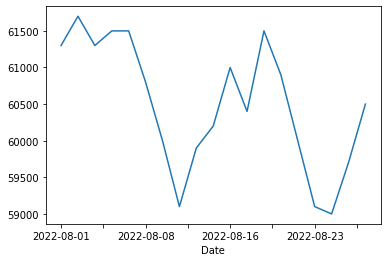

In [69]:
# 기준 구간 시계열 차트
close[start_date:end_date].plot();

In [84]:
base = close[start_date:end_date]
base

Date
2022-08-01    61300
2022-08-02    61700
2022-08-03    61300
2022-08-04    61500
2022-08-05    61500
2022-08-08    60800
2022-08-09    60000
2022-08-10    59100
2022-08-11    59900
2022-08-12    60200
2022-08-16    61000
2022-08-17    60400
2022-08-18    61500
2022-08-19    60900
2022-08-22    60000
2022-08-23    59100
2022-08-24    59000
2022-08-25    59700
2022-08-26    60500
Name: Close, dtype: int64

In [85]:
base_norm = (base - base.min()) / (base.max() - base.min())
base_norm

Date
2022-08-01    0.851852
2022-08-02    1.000000
2022-08-03    0.851852
2022-08-04    0.925926
2022-08-05    0.925926
2022-08-08    0.666667
2022-08-09    0.370370
2022-08-10    0.037037
2022-08-11    0.333333
2022-08-12    0.444444
2022-08-16    0.740741
2022-08-17    0.518519
2022-08-18    0.925926
2022-08-19    0.703704
2022-08-22    0.370370
2022-08-23    0.037037
2022-08-24    0.000000
2022-08-25    0.259259
2022-08-26    0.555556
Name: Close, dtype: float64

In [92]:
# 윈도우 사이즈
window_size = len(base)

# 예측 기간
pre_date = 5

# 검색 횟수
moving_cnt = len(df) - window_size - pre_date - 1

In [88]:
def cosine_similarity(x, y):
    return np.dot(x, y) / (np.sqrt(np.dot(x, x)) * np.sqrt(np.dot(y, y)))

In [89]:
# 유사도 저장 딕셔너리
sim_list = []

for i in range(moving_cnt):
    target = close[i:i+window_size]
    
    # Normalize
    target_norm = (target - target.min()) / (target.max() - target.min())
    
    # 코사인 유사도 저장(1에 가까울 수록 유사도 높음,https://wikidocs.net/24603)
    cosine = cosine_similarity(base_norm, target_norm)
    
    # 코사인 유사도 <- i(인덱스), 시계열데이터 함께 저장
    sim_list.append(cosine)

In [93]:
pd.Series(sim_list).sort_values(ascending=False).head(20)

4017    0.958201
348     0.957662
3318    0.950595
5470    0.950405
1710    0.947660
1726    0.946445
14      0.946010
3317    0.945347
2287    0.945292
1684    0.943519
5238    0.942952
2727    0.942440
5237    0.941668
3069    0.941408
2737    0.941203
3789    0.940296
3326    0.940219
2137    0.939356
5421    0.939147
1683    0.939095
dtype: float64

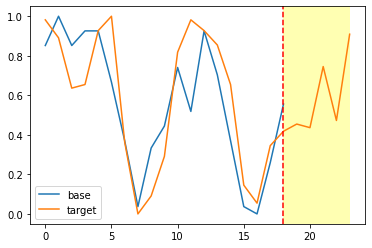

In [94]:
idx = 4017

top = close[idx:idx+window_size+pre_date]
top_norm = (top - top.min()) / (top.max() - top.min())

plt.plot(base_norm.values, label='base')
plt.plot(top_norm.values, label='target')
plt.axvline(x=len(base_norm)-1, c='r', linestyle='--')
plt.axvspan(len(base_norm.values)-1, len(top_norm.values)-1, facecolor='yellow', alpha=0.3)
plt.legend()
plt.show()

In [119]:
class PatternFinder():
    def __init__(self, pre_date=5):
        self.pre_date = pre_date
    
    def set_stock(self):
        
        self.data = pd.read_csv('sam22y.csv').set_index("Date",drop=True)
        self.close = self.data['Close']
        self.change = self.data['Change']
        return self.data
        
    def search(self, start_date, end_date, threshold=0.95):
        base = self.close[start_date:end_date]
        self.base_norm = (base - base.min()) / (base.max() - base.min())
        self.base = base
        
        display(base)
        
        window_size = len(base)
        moving_cnt = len(self.data) - window_size - self.pre_date - 1
        cos_sims = self.__cosine_sims(moving_cnt, window_size)
        
        self.window_size = window_size
        cos_sims = cos_sims[cos_sims > threshold]
        return cos_sims
    
    
    def __cosine_sims(self, moving_cnt, window_size):
        def cosine_similarity(x, y):
            return np.dot(x, y) / (np.sqrt(np.dot(x, x)) * np.sqrt(np.dot(y, y)))
        
        # 유사도 저장 딕셔너리
        sim_list = []

        for i in range(moving_cnt):
            target = self.close[i:i+window_size]

            # Normalize
            target_norm = (target - target.min()) / (target.max() - target.min())

            # 코사인 유사도 저장
            cosine = cosine_similarity(self.base_norm, target_norm)

            # 코사인 유사도 <- i(인덱스), 시계열데이터 함께 저장
            sim_list.append(cosine)
        return pd.Series(sim_list).sort_values(ascending=False)

    
    def plot_pattern(self, idx, pre_date=5):
        if pre_date != self.pre_date:
            self.pre_date = pre_date
            
        top = self.close[idx:idx+self.window_size+pre_date]
        top_norm = (top - top.min()) / (top.max() - top.min())

        plt.plot(self.base_norm.values, label='base')
        plt.plot(top_norm.values, label='target')
        plt.axvline(x=len(self.base_norm)-1, c='r', linestyle='--')
        plt.axvspan(len(self.base_norm.values)-1, len(top_norm.values)-1, facecolor='yellow', alpha=0.3)
        plt.legend()
        plt.show()
        
        
        preds = self.change[idx+self.window_size: idx+self.window_size+pre_date]
        display(preds)
        print(f'pred: {preds.mean()*100} % ')

    
    def stat_prediction(self, result, pre_date=5):
        idx_list = list(result.keys())
        mean_list = []
        for idx in idx_list:
            pred = self.change[idx+self.window_size: idx+self.window_size+pre_date]
            mean_list.append(pred.mean())
        return np.array(mean_list)

In [120]:
p = PatternFinder()

In [121]:
p.set_stock()

,Open,High,Low,Close,Adj Close,Volume,Change
Date,,,,,,,
2000-01-04,6000,6110,5660,6110,4623.467773,74195000,0.00
2000-01-05,5800,6060,5520,5580,4222.413086,74680000,-8.67
2000-01-06,5750,5780,5580,5620,4252.679688,54390000,0.72
2000-01-07,5560,5670,5360,5540,4192.145020,40305000,-1.42
2000-01-10,5600,5770,5580,5770,4366.187500,46880000,4.15
...,...,...,...,...,...,...,...
2022-08-22,60300,60400,59800,60000,60000.000000,8259865,-1.48
2022-08-23,59000,59600,59000,59100,59100.000000,9041629,-1.50
2022-08-24,59200,59500,59000,59000,59000.000000,8888486,-0.17


In [122]:
result = p.search('2022-08-01', '2022-08-26')

Date
2022-08-01    61300
2022-08-02    61700
2022-08-03    61300
2022-08-04    61500
2022-08-05    61500
2022-08-08    60800
2022-08-09    60000
2022-08-10    59100
2022-08-11    59900
2022-08-12    60200
2022-08-16    61000
2022-08-17    60400
2022-08-18    61500
2022-08-19    60900
2022-08-22    60000
2022-08-23    59100
2022-08-24    59000
2022-08-25    59700
2022-08-26    60500
Name: Close, dtype: int64

In [123]:
pred = p.stat_prediction(result)
pred

array([ 0.428,  0.048, -0.298,  0.482])

In [125]:
result

4017    0.958201
348     0.957662
3318    0.950595
5470    0.950405
dtype: float64

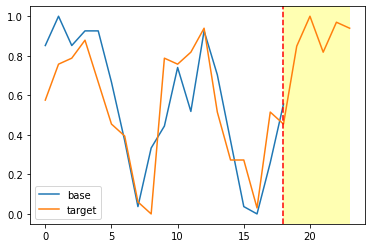

Date
2022-05-17    1.96
2022-05-18    0.74
2022-05-19   -0.88
2022-05-20    0.74
2022-05-23   -0.15
Name: Change, dtype: float64

pred: 48.20000000000001 % 


In [129]:
p.plot_pattern(5470)